<a href="https://colab.research.google.com/github/kumiori/mec647/blob/francoisfernet---mesh/exemple_ep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML


In [15]:
branch_name = 'main'

!rm -rf mec647
try:
  !git clone -b {branch_name} https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git



Cloning into 'mec647'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (1023/1023), done.
remote: Compressing objects: 100% (767/767), done.
remote: Total 1023 (delta 510), reused 531 (delta 230), pack-reused 0
Receiving objects: 100% (1023/1023), 18.34 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (510/510), done.


In [16]:
sys.path.append('mec647/')

In [19]:
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD

from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

# meshes
import meshes
from meshes import primitives

import models
from models import DamageElasticityModel as Brittle

In [21]:
import numpy as np
import yaml
import json
import sys
import os
from pathlib import Path

from mpi4py import MPI

import petsc4py
from petsc4py import PETSc

import dolfinx
import dolfinx.plot
from dolfinx import log
import ufl

import algorithms
from algorithms import am

from dolfinx.io import XDMFFile

import logging

logging.basicConfig(level=logging.INFO)

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)
import matplotlib.pyplot as plt
import pyvista 
from pyvista.utilities import xvfb


# visualisation
from utils import viz
import matplotlib.pyplot as plt
from utils.viz import plot_mesh, plot_vector, plot_scalar
generateStepwiseOutput=True

In [23]:
# Parameters
parameters = {
    'loading': {
        'min': 0.4,
        'max': 1.,
        'steps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 100,
        'Ly': 200, 
        'L0':15,
        's':30,
    },
    'model': {
        'E': 1E-1,
        'nu': .4,
        'w1': 1.,
        'ell': 10, # 100/35,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 250,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            },
        },
          'damage_elasticity': {
            "max_it": 2000,
            "alpha_rtol": 1.0e-4,
            "criterion": "alpha_H1"
          }
    }
}

In [30]:
def mesh_rh(name,
                    Lx,
                    Ly,
                    L0, 
                    s,
                    lc,
                    lc_fine,
                    tdim,
                    order=1,
                    msh_file=None,
                    sep=0.1,
                    comm=MPI.COMM_WORLD):
    if comm.rank == 0:

        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        gmsh.option.setNumber("Mesh.Algorithm", 6)
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
        p0 = model.geo.addPoint(0.0, 0.0, 0, lc, tag=0)
        p1 = model.geo.addPoint(Lx, 0.0, 0, lc, tag=1)
        p2 = model.geo.addPoint(Lx, Ly, 0.0, lc, tag=2)
        p3 = model.geo.addPoint(0, Ly, 0, lc, tag=3)
        #pLa= model.geo.addPoint(0, Ly/2-s/2, 0, lc, tag=4)
        pRa= model.geo.addPoint(Lx, Ly/2+s/2-sep, 0, lc_fine, tag=6)
        pRb= model.geo.addPoint(Lx, Ly/2+s/2+sep, 0, lc_fine, tag=7)
        pLa= model.geo.addPoint(0, Ly/2-s/2-sep, 0, lc_fine, tag=8)
        pLb= model.geo.addPoint(0, Ly/2-s/2+sep, 0, lc_fine, tag=5)
        plM= model.geo.addPoint(L0, Ly/2-s/2, 0, lc_fine, tag=9)
        prM= model.geo.addPoint(Lx-L0, Ly/2+s/2, 0, lc_fine, tag=10)
        # points = [p0, p1, p2, p3]
        bottom = model.geo.addLine(p0, p1, tag=0)
        #right = model.geo.addLine(p1, p2, tag=1)
        rightB = model.geo.addLine(p1, pRa, tag=1)
        crackBR= model.geo.addLine(pRa, prM, tag=2)
        crackTR= model.geo.addLine(prM, pRb, tag=3)
        rightT = model.geo.addLine(pRb, p2, tag=4)
        top = model.geo.addLine(p2, p3, tag=5)
        #left=model.geo.addLine(p3, p0, tag=6)
        leftT = model.geo.addLine(p3, pLb, tag=6)
        crackTL = model.geo.addLine(pLb, plM, tag=7)
        crackBL = model.geo.addLine(plM, pLa, tag=8)
        leftB = model.geo.addLine(pLa, p0, tag=9)
        #cloop1 = model.geo.addCurveLoop([bottom, right, top, left])
        cloop1 = model.geo.addCurveLoop([crackTR, rightT, top, leftT, crackTL, crackBL, leftB, bottom, rightB, crackBR])
        # surface_1 =
        model.geo.addPlaneSurface([cloop1])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(tdim)]
        model.addPhysicalGroup(tdim, surface_entities, tag=5)
        model.setPhysicalName(tdim, 5, "Rectangle surface")

        # Set mesh size via points
        # gmsh.model.mesh.setSize(points, lc)  # heuristic

        # gmsh.model.mesh.optimize("Netgen")

        # Set geometric order of mesh cells
        gmsh.model.mesh.setOrder(order)

        # Define physical groups for subdomains (! target tag > 0)
        # domain = 1
        # gmsh.model.addPhysicalGroup(tdim, [v[1] for v in volumes], domain)
        # gmsh.model.setPhysicalName(tdim, domain, 'domain')
        #gmsh.model.addPhysicalGroup(tdim - 2, [9], tag=18)
        #gmsh.model.setPhysicalName(tdim - 2, 18, "nodeLeftMiddle")
        gmsh.model.addPhysicalGroup(tdim - 1, [0], tag=10)
        gmsh.model.setPhysicalName(tdim - 1, 10, "bottom")
        gmsh.model.addPhysicalGroup(tdim - 1, [5], tag=11)
        gmsh.model.setPhysicalName(tdim - 1, 11, "top")
        
        gmsh.model.addPhysicalGroup(tdim - 1, [6, 7, 8, 9], tag=12)
        #gmsh.model.addPhysicalGroup(tdim - 1, [6], tag=12)
        gmsh.model.setPhysicalName(tdim - 1, 12, "left")
        gmsh.model.addPhysicalGroup(tdim - 1, [1, 2, 3, 4], tag=13)
        #gmsh.model.addPhysicalGroup(tdim - 1, [1], tag=13)
        gmsh.model.setPhysicalName(tdim - 1, 13, "right")
        gmsh.model.addPhysicalGroup(tdim - 1, [7], tag=14)
        gmsh.model.setPhysicalName(tdim - 1, 14, "Lliptop")
        gmsh.model.addPhysicalGroup(tdim - 1, [8], tag=15)
        gmsh.model.setPhysicalName(tdim - 1, 15, "Llipbot")
        gmsh.model.addPhysicalGroup(tdim - 1, [2], tag=16)
        gmsh.model.setPhysicalName(tdim - 1, 16, "Rliptop")
        gmsh.model.addPhysicalGroup(tdim - 1, [3], tag=17)
        gmsh.model.setPhysicalName(tdim - 1, 17, "Rlipbot")
        
        model.mesh.generate(tdim)

        # Define physical groups for interfaces (! target tag > 0)
        # surface = 1
        # gmsh.model.addPhysicalGroup(tdim - 1, [s[1] for s in surfaces], surface)
        # gmsh.model.setPhysicalName(tdim - 1, surface, 'surface')
        """surface_grip_left = 2
        gmsh.model.addPhysicalGroup(tdim - 1, [s0], surface_grip_left)
        gmsh.model.setPhysicalName(tdim - 1, surface_grip_left, 'surface_grip_left')
        surface_grip_right = 3
        gmsh.model.addPhysicalGroup(tdim - 1, [s1], surface_grip_right)
        gmsh.model.setPhysicalName(tdim - 1, surface_grip_right, 'surface_grip_right')
        surface_plane_left = 4
        gmsh.model.addPhysicalGroup(tdim - 1, [s2], surface_plane_left)
        gmsh.model.setPhysicalName(tdim - 1, surface_plane_left, 'surface_plane_left')
        surface_plane_right = 5
        gmsh.model.addPhysicalGroup(tdim - 1, [s3], surface_plane_right)
        gmsh.model.setPhysicalName(tdim - 1, surface_plane_right, 'surface_plane_right')"""
        # Optional: Write msh file
        if msh_file is not None:
            gmsh.write(msh_file)
            # gmsh.write(name + ".step")

    return gmsh.model if comm.rank == 0 else None, tdim


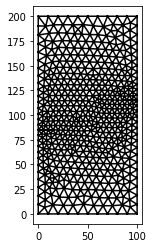

In [33]:
# Mesh

Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
L0 = parameters["geometry"]["L0"]
s = parameters["geometry"]["s"]
geom_type = parameters["geometry"]["geom_type"]
prefac=100

gmsh_model, tdim = mesh_rh(geom_type,
                                    Lx, 
                                    Ly, 
                                    L0, 
                                    s,
                                    parameters["model"]["ell"], 
                                    parameters["model"]["ell"]/2, 
                                    sep=3E-1, 
                                    tdim=2)

"""gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    parameters.get("model").get("ell")/3, 
                                    tdim=2)"""

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

In [34]:
"""
mesh.topology.create_entities(tdim - 1)
def left_corner(x):
    return np.logical_and(x[0] < Lx/4, x[1] < Ly/2)
def middle_area(x):
    return np.logical_and(x[1] < Ly/2+3/4*s, x[1] > Ly/2-3/4*s)
edges = dolfinx.mesh.locate_entities(mesh, tdim-1, middle_area)
mesh_refined_local2 = dolfinx.mesh.refine(mesh, edges, redistribute=True)
edges = dolfinx.mesh.locate_entities(mesh_refined_local2, tdim-1, middle_area)
mesh_refined_local3 = dolfinx.mesh.refine(mesh_refined_local2, edges, redistribute=True)
plt.figure()
ax = plot_mesh(mesh_refined_local3)
fig = ax.get_figure()
fig.savefig(f"mesh_refined_local_bulk.png")
"""
usedMesh=mesh # Enables opportunity to improve mesh at specific places, might lead to deformed elements
# Functional Setting

element_u = ufl.VectorElement("Lagrange", usedMesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", usedMesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(usedMesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(usedMesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Pack state
state = {"u": u, "alpha": alpha}

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")



dx = ufl.Measure("dx", domain = usedMesh)
ds = ufl.Measure("ds", domain = usedMesh)


# Boundary sets
dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))
dofs_alpha_bottom = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[1], 0.))
dofs_alpha_top = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[1], Lx))


dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))
dofs_u_top = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[1], Ly))
dofs_u_bottom = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[1], 0))

# Boundary data
u_.interpolate(lambda x: (np.zeros_like(x[0]), prefac*np.ones_like(x[1])))

# Bounds (nontrivial)
alpha_lb.interpolate(lambda x: np.zeros_like(x[0]))
alpha_ub.interpolate(lambda x: np.ones_like(x[0]))

# Boundary conditions
bcs_u = [
         dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
                      dofs_u_bottom,
                      V_u),
         dirichletbc(u_, dofs_u_top)
         ]

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_bottom, dofs_alpha_top]),
                         V_alpha)
]

bcs = {"bcs_u": bcs_u, "bcs_alpha": bcs_alpha}

model = Brittle(parameters["model"])

total_energy = model.total_energy_density(state) * dx
solver = am.AlternateMinimisation(total_energy,
                         state,
                         bcs,
                         parameters.get("solvers"),
                         bounds=(alpha_lb, alpha_ub)
                         )

In [27]:
# Loop for evolution
loads = np.linspace(parameters.get("loading").get("min"),
                    parameters.get("loading").get("max"),
                    parameters.get("loading").get("steps"))

data = {
    'elastic': [],
    'surface': [],
    'total': [],
    'load': []
}
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

for (i_t, t) in enumerate(loads):
  # update boundary conditions

  u_.interpolate(lambda x: ( np.zeros_like(x[0]), t*prefac*np.ones_like(x[1])))
  u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # update lower bound for damage
  alpha.vector.copy(alpha_lb.vector)
  alpha.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT,
                        mode=PETSc.ScatterMode.FORWARD)

  # solve for current load step
  print(f"Solving timestep {i_t}, load: {t}")

  solver.solve()

  # postprocessing
  # global

  surface_energy = assemble_scalar(dolfinx.fem.form(model.damage_dissipation_density(state) * dx))

  elastic_energy = assemble_scalar(
        dolfinx.fem.form(model.elastic_energy_density(state) * dx))
  
  data.get('elastic').append(elastic_energy)
  data.get('surface').append(surface_energy)
  data.get('total').append(surface_energy+elastic_energy)
  data.get('load').append(t)

  print(f"Solved timestep {i_t}, load: {t}")
  print(f"Elastic Energy {elastic_energy:.3g}, Surface energy: {surface_energy:.3g}")
  print("\n\n")
  if generateStepwiseOutput:
    if(surface_energy>1 and i_t%25==0):
    #if(i_t>1050 and i_t<1100):
        _plt = plot_scalar(alpha, plotter, subplot=(0, 0))
        _plt.screenshot(f"./plots/s30/alpha"+str(i_t)+".png")
    #if i_t>1100:
    #    break
  if(i_t>20 and  elastic_energy<1E-3 and elastic_energy<surface_energy):
      #Brute force approach to determine, whether we have already reached a crack propagation state
      break

  # savings?

Solving timestep 0, load: 0.4
  0 SNES Function norm 2.006532998436e+02 
  1 SNES Function norm 2.005568178406e+02 
  2 SNES Function norm 2.003638538346e+02 
  3 SNES Function norm 1.999779258224e+02 
  4 SNES Function norm 1.992060697982e+02 
  5 SNES Function norm 1.976623577497e+02 
  6 SNES Function norm 1.945749336528e+02 
  7 SNES Function norm 1.884000854589e+02 
  8 SNES Function norm 1.760503890712e+02 
  9 SNES Function norm 1.513509962958e+02 
 10 SNES Function norm 1.019522107449e+02 
 11 SNES Function norm 3.154639643105e+00 
 12 SNES Function norm 5.321747591379e-14 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 0, load: 0.4
Elastic Energy 377, Surface energy: 0



Solving timestep 1, load: 0.4666666666666667
  0 SNES Function norm 3.344221664061e+01 
  1 SNES Function norm 6.682431219200e-14 
  0 SNES Function norm 0.000000000000e+00 
Solved timestep 1, load: 0.4666666666666667
Elastic Energy 513, Surface energy: 0



Solving timestep 2, load: 0.53333333333

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

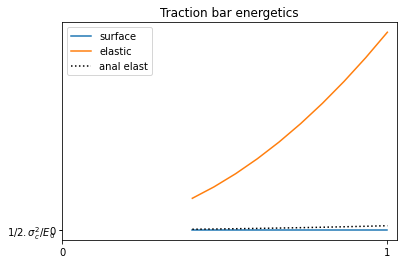

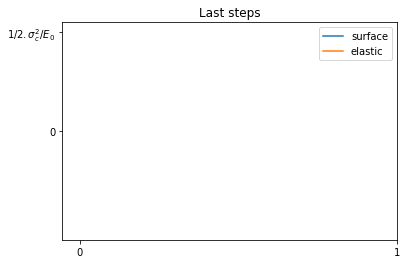

In [28]:
plt.figure()
plt.plot(data.get('load'), data.get('surface'), label='surface')
plt.plot(data.get('load'), data.get('elastic'), label='elastic')
plt.plot(data.get('load'), [1./2. * t**2*Lx for t in data.get('load')], label='anal elast', ls=':', c='k')

plt.title('Traction bar energetics')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])
plt.savefig("energetics.png")

# savings?
plt.figure()
plt.plot(data.get('load')[:-40], data.get('surface')[:-40], label='surface')
plt.plot(data.get('load')[:-40], data.get('elastic')[:-40], label='elastic')

plt.title('Last steps')
plt.legend()
plt.yticks([0, 1/20], [0, '$1/2.\sigma_c^2/E_0$'])
plt.xticks([0, 1], [0, 1])
plt.savefig("lastSteps.png")



plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

# _plt = plot_scalar(u_.sub(0), plotter, subplot=(0, 0))
_plt = plot_vector(u, plotter, subplot=(0, 1))
_plt.screenshot(f"displacement_MPI.png")


xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True

plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

_plt = plot_scalar(alpha, plotter, subplot=(0, 0))
_plt.screenshot(f"alpha2.png")